The shape of each digit-image from 0-9 is:  [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]


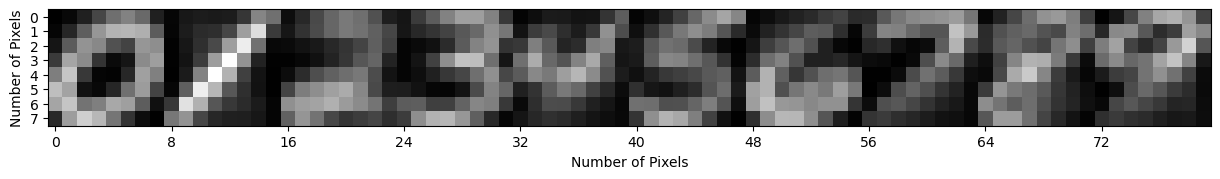

In [5]:

'''
Handwritten Digit Classification with Generative Models
'''

'''
Load the data and plot the means for each of the digit classes in the training data
(include these in your report). Given that each image is a vector of size 64, the mean will
be a vector of size 64 which needs to be reshaped as an 8 × 8 2D array to be rendered as an
image. Plot all 10 means side by side using the same scale
'''

import data
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_means(train_data, train_labels):
    means = []
    for i in range(0, 10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)
        # Compute mean of class i
        digits_mean = np.mean(i_digits, axis=0)
        means.append(digits_mean.reshape((8,8)))


    # Plot all means on same axis
    print("The shape of each digit-image from 0-9 is: ",[digit.shape for digit in means])
    all_concat = np.concatenate(means, 1)
    plt.figure(figsize=(15, 120))
    plt.imshow(all_concat, cmap='gray')
    plt.xticks([i for i in range (80) if i%8 == 0])
    plt.yticks([i for i in range (8)])
    plt.xlabel("Number of Pixels")
    plt.ylabel("Number of Pixels")
    plt.show()

if __name__ == '__main__':
    train_data, train_labels, _, _ = data.load_all_data_from_zip('data.zip', 'data')
    plot_means(train_data, train_labels)

In [6]:
def compute_mean_mles(train_data, train_labels):
    '''
    Compute the mean estimate for each digit class

    Should return a numpy array of size (10,64)
    The ith row will correspond to the mean estimate for digit class i
    '''
    means = np.zeros((10, 64))
    # Compute means
    for i in range(10):
        means[i,] = train_data[train_labels == i].mean(0)
        
    return means

def compute_sigma_mles(train_data, train_labels):
    '''
    Compute the covariance estimate for each digit class

    Should return a three dimensional numpy array of shape (10, 64, 64)
    consisting of a covariance matrix for each digit class 
    '''
    covariances = np.zeros((10, 64, 64))
    # Compute covariances
    
    for i in range(0,10):
        data_i = train_data[train_labels == i]
        means_i = data_i.mean(0).reshape((1, 64))
        N =  data_i.shape[0]
        Cov_i = np.zeros((64, 64))
        for j in range(N):
            train_i = data_i[j, ].reshape((1, 64))
            X_minus_mu = train_i -means_i
            Cov_i = Cov_i + np.dot(X_minus_mu.T, X_minus_mu)
            
        stability = np.identity(64) * 0.01    #Adding 0.01 for numerical stability
        covariances[i, : , : ] = (Cov_i / N) + stability
        
    return covariances

def plot_cov_diagonal(covariances):
    # Plot the log-diagonal of each covariance matrix side by side
    Covs = []
    for i in range(10):
        cov_diag = np.diag(covariances[i])
        cov_diag = np.log((cov_diag))
        cov_diag = np.reshape(cov_diag, (8,8))
        Covs.append(cov_diag)
        
    Covs_concat = np.concatenate(Covs, 1)
    plt.figure(figsize=(15, 120))
    plt.imshow(Covs_concat, cmap='gray')
    plt.xticks([i for i in range (80) if i%8 == 0])
    plt.yticks([i for i in range (8)])
    plt.xlabel("Number of Pixels")
    plt.ylabel("Number of Pixels")
    plt.show()

def generative_likelihood(digits, means, covariances):
    '''
    Compute the generative log-likelihood:
        log p(x|y,mu,Sigma)

    Should return an n x 10 numpy array 
    '''
    
    N = digits.shape[0]
    d = digits.shape[1]   
    log_likelihood = np.zeros((N, 10))
    # digits here is the train_data or test_data
    for i in range(N):
        X = digits[i, : ]
        
        for j in range(10):
            means_i = means[j, : ].reshape((1, 64))
            Covs_i = covariances[j, : , : ]
            
            Covs_inv = np.linalg.inv(Covs_i)
            X_minus_mu = X - means_i
            A = (-d*0.5)*math.log(2*math.pi)   #constant term
            B = (-0.5) * math.log(np.linalg.det(Covs_i)) # log of inverse of covariance 
            C = (-0.5)*(np.dot(np.dot(X_minus_mu, Covs_inv), X_minus_mu.T))  #log of the term in the exponenetial bracket
            C = C[0][0]
            log_likelihood[i][j] =  A + B + C
       
    return log_likelihood
    

def conditional_likelihood(digits, means, covariances):
    '''
    Compute the conditional likelihood:

        log p(y|x, mu, Sigma)

    This should be a numpy array of shape (n, 10)
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''
    XcondY_likelihood = generative_likelihood_NB(digits, means, covariances)
    N = digits.shape[0]
    log_posterior_prob = np.zeros((N, 10))
    prob_y = 0.1 #given p(y=k) = 1/10
    for i in range(N):
        X_condY = XcondY_likelihood[i,:]
        P_x = 0.1*np.sum(np.exp(X_condY)) #p(x) = Sum of (x|y=k)*p(y=k) for all k's
        
        for j in range(10):
            #Adding the remaining log probablities to get the posterior probablity
            log_posterior_prob[i][j] = X_condY[j] + math.log(prob_y) - math.log(P_x)

    return log_posterior_prob
    

def avg_conditional_likelihood(digits, labels, means, covariances):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, mu, Sigma) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    # Compute as described above and return

    N_data = cond_likelihood.shape[0]
    Avg_cond_likelihood = 0
    for i in range(N_data):
        label = int(labels[i])
        Avg_cond_likelihood = Avg_cond_likelihood + cond_likelihood[i][label]
        
    Avg_cond_likelihood = Avg_cond_likelihood / N_data
    
    return Avg_cond_likelihood


def classify_data(digits, means, covariances):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    # Compute and return the most likely class
    pred_digit = np.argmax(cond_likelihood, axis = 1)

    return pred_digit

def get_accuracy(labels, pred):
    N = labels.shape[0]
    correct = 0
    for i in range(N):
        if int(labels[i]) == int(pred[i]):
            correct = correct + 1
    
    acc = (correct/N)*100
    return acc

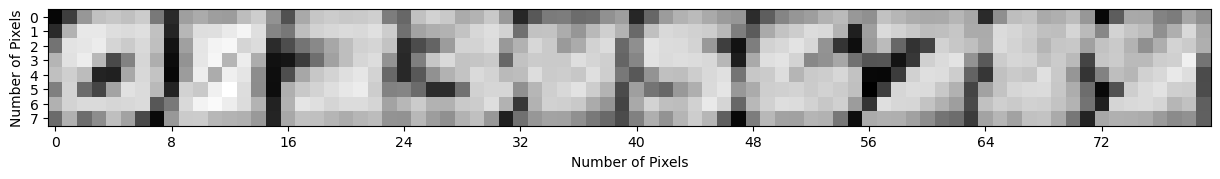



For the training data, the average conditional log-likelihood is = -0.12462443666862896


For the test data, the average conditional log-likelihood is = -0.19667320325525495


The accuracy on the train Set: 98.14285714285714 %


The accuracy on the test Set: 97.275 %


In [7]:
def main():
    train_data, train_labels, test_data, test_labels = data.load_all_data('data')

    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)

    # Evaluation
    # plot covariance
    #Plot an 8x8 image of the log of the diagonal elements of each covariance matrix
    plot_cov_diagonal(covariances)
    print('\n')

    # Evaluation
    #Get average conditional probabilites
    avg_cond_prob_train = avg_conditional_likelihood(train_data, train_labels, means, covariances)
    print('For the training data, the average conditional log-likelihood is = {}'.format(avg_cond_prob_train))
    print('\n')

    avg_cond_prob_test = avg_conditional_likelihood(test_data, test_labels, means, covariances)
    print('For the test data, the average conditional log-likelihood is = {}'.format(avg_cond_prob_test))
    print('\n')

    #Get accuracy scores
    pred_train = classify_data(train_data, means, covariances)
    train_accuracy = get_accuracy(train_labels, pred_train)
    print("The accuracy on the train Set: {} %".format(train_accuracy))
    print('\n')
    
    pred_test = classify_data(test_data, means, covariances)
    test_accuracy = get_accuracy(test_labels, pred_test)
    print("The accuracy on the test Set: {} %".format(test_accuracy))
    

if __name__ == '__main__':
    main()

In [11]:
'''
Naive Bayes classifier

'''
def binarize_data(pixel_values):
    '''
    Binarize the data by thresholding around 0.5
    '''
    return np.where(pixel_values > 0.5, 1.0, 0.0)

def compute_parameters(train_data, train_labels):
    '''
    Compute the eta MAP estimate/MLE with augmented data

    You should return a numpy array of shape (10, 64)
    where the ith row corresponds to the ith digit class.
    '''
    eta = np.zeros((10, 64))
    for i in range(10):
        
        pixels_ON = np.ones((1,64)) #Adding the training case with all pixels ON for each class
        pixels_OFF = np.zeros((1,64)) #Adding the training case with all pixels OFF for each class
        prior = np.concatenate((pixels_ON, pixels_OFF), axis=0) #getting prior as pseudo counts
        train_data = np.concatenate((train_data, prior), axis=0)
        
        #Balancing the two pseudo prior-training set with labels set
        label_i = np.array([i])
        array_label = np.concatenate((label_i, label_i), axis=0) 
        train_labels = np.concatenate((train_labels, array_label), axis=0)

    for i in range(10):
        digit_i = train_data[train_labels == i]
        N = digit_i.shape[0]
        for j in range(64):
            col = digit_i[:,j]
            b_1s = np.sum(col== 1) #get the pixels = 1
            eta[i, j] = b_1s/N
      
    return eta

def plot_images(class_images):
    '''
    Plot each of the images corresponding to each class side by side in grayscale
    '''
    images_array = []
    for i in range(10):
        img_i = class_images[i]
        # ...
        img_i = np.reshape(img_i, (8, 8))
        images_array.append(img_i)

    images_concat = np.concatenate(images_array, 1)
    plt.figure(figsize=(15, 120))
    plt.imshow(images_concat, cmap='gray')
    plt.xticks([i for i in range (80) if i%8 == 0])
    plt.yticks([i for i in range (8)])
    plt.xlabel("Number of Pixels")
    plt.ylabel("Number of Pixels")
    plt.show()

def generate_new_data(eta):
    '''
    Sample a new data point from your generative distribution p(x|y,theta) for
    each value of y in the range 0...10

    Plot these values
    '''
    generated_data = np.zeros((10, 64))

    for i in range(10):
        for j in range(64):
            generated_data[i, j] = np.random.binomial(1, eta[i,j])
    plot_images(generated_data)

def generative_likelihood_NB(bin_digits, eta):
    '''
    Compute the generative log-likelihood:
        log p(x|y, eta)

    Should return an n x 10 numpy array 
    '''
    N = bin_digits.shape[0]
    log_likelihood = np.zeros((N, 10))
    pixels = eta.shape[1]
    for i in range(10):
        log_lh = 0        
        for j in range(pixels):
             log_lh = log_lh + bin_digits[:,j]*np.log(eta[i,j]) + (1-bin_digits[:,j])*np.log((1-eta[i,j]))
        log_likelihood[:, i] = log_lh

    return log_likelihood
    

def conditional_likelihood_NB(bin_digits, eta):
    '''
    Compute the conditional likelihood:

        log p(y|x, eta)

    This should be a numpy array of shape (n, 10)
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''
    
    XcondY_likelihood = generative_likelihood_NB(bin_digits, eta)
    N = bin_digits.shape[0]
    log_posterior_prob = np.zeros((N, 10))
    prob_y = 0.1 #given p(y=k) = 1/10
    for i in range(N):
        X_condY = XcondY_likelihood[i,:]
        P_x = 0.1*np.sum(np.exp(X_condY)) #p(x) = Sum of (x|y=k)*p(y=k) for all k's
        
        for j in range(10):
            #Adding the remaining log probablities to get the posterior probablity
            log_posterior_prob[i][j] = X_condY[j] + math.log(prob_y) - math.log(P_x)

    return log_posterior_prob


def avg_conditional_likelihood_NB(bin_digits, labels, eta):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, eta) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    N_data = bin_digits.shape[0]
    cond_likelihood = conditional_likelihood_NB(bin_digits, eta)

    Avg_cond_likelihood = 0
    for i in range(N_data):
        label = int(labels[i])
        Avg_cond_likelihood = Avg_cond_likelihood + cond_likelihood[i][label]
        
    Avg_cond_likelihood = Avg_cond_likelihood/N_data
    
    return Avg_cond_likelihood


def classify_data_NB(bin_digits, eta):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_likelihood = conditional_likelihood_NB(bin_digits, eta)
    # Compute and return the most likely class
    pred_digit = np.argmax(cond_likelihood, axis = 1)

    return pred_digit


def get_accuracy_NB(labels, pred):
    N = labels.shape[0]
    correct = 0
    for i in range(N):
        if int(labels[i]) == int(pred[i]):
            correct = correct + 1
    
    acc = (correct/N)*100
    return acc

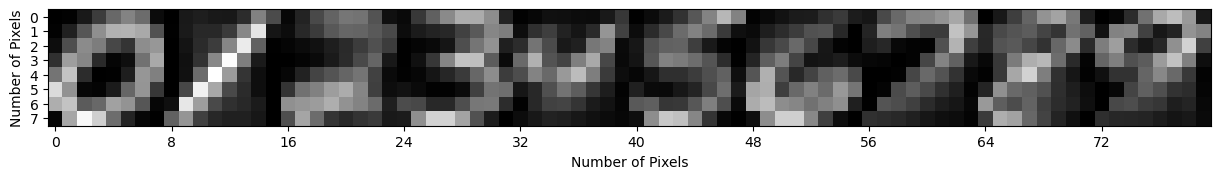

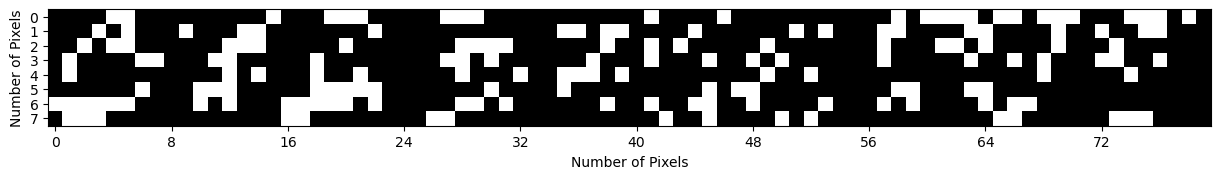



For the training data, the average conditional log-likelihood is = -0.9437538618002533


For the test data, the average conditional log-likelihood is = -0.987270433725359


The accuracy on the train Set: 77.41428571428571 %


The accuracy on the test Set: 76.425 %


In [12]:
def main():
    train_data, train_labels, test_data, test_labels = data.load_all_data('data')
    
    #Convert the real-valued features x into binary features b using 0.5 as a threshold
    train_data, test_data = binarize_data(train_data), binarize_data(test_data)

    #Fit the model using prior as psuedo counts
    eta = compute_parameters(train_data, train_labels)

    #Plot of the ηk vectors
    plot_images(eta)

    #Generate new data for plots
    #Plot of the sample point/class generated from the generative model
    generate_new_data(eta)
    print('\n')

    # Evaluation
    #Get average conditional probabilites
    avg_cond_prob_train = avg_conditional_likelihood_NB(train_data, train_labels, eta)
    print('For the training data, the average conditional log-likelihood is = {}'.format(avg_cond_prob_train))
    print('\n')

    avg_cond_prob_test = avg_conditional_likelihood_NB(test_data, test_labels, eta)
    print('For the test data, the average conditional log-likelihood is = {}'.format(avg_cond_prob_test))
    print('\n')

    #Q2.2.6: Get accuracy scores
    pred_train = classify_data_NB(train_data, eta)
    train_accuracy = get_accuracy_NB(train_labels, pred_train)
    print("The accuracy on the train Set: {} %".format(train_accuracy))
    print('\n')
    
    pred_test = classify_data(test_data, eta)
    test_accuracy = get_accuracy_NB(test_labels, pred_test)
    print("The accuracy on the test Set: {} %".format(test_accuracy))

if __name__ == '__main__':
    main()